# Proyecto 2
## Data Science, sección 40
## Grupo 1
Javier Alejandro Ovalle Chiquín, 22103  
José Ángel Morales Farfan, 22689  
Ricardo Josué Morales Contreras, 22289  
Karen Daniela Pineda Ventura 231132

# Predicción de calificaciones de resúmenes (content & wording)


### Situación problemática
Los estudiantes realizan resúmenes en respuesta a una consigna, luego evaluadores puntúan cada resumen en dos factores: content (Si el resumen cubre lo solicitado) y wording (calidad de la redacción). Evaluar manualmente esto es costoso, lento y potencialmente inconsistente. Por lo que, automatizar la evaluación con modelos de PLN puede permitir retroalimentación a escala, detectar rápido resúmenes que necesiten intervención y homogeneizar criterios.

### Problema científico
Construir modelos de Procesamiento del Lenguaje Natural que, a partir del texto del resumen y del enunciado del prompt, predigan dos puntuaciones continuas (content y wording) de forma que se reduzca la discrepancia con respecto a las evaluaciones realizadas manualmente.

### Objetivos

Objetivo general

- Diseñar, implementar y evaluar un pipeline de PLN que prediga las puntuaciones content y wording de resúmenes estudiantiles con una evaluación cuantitativa reproducible (RMSE, correlaciones).

Objetivos específicos

- Implementar preprocesamiento reproducible (tokenización, limpieza) y documentar su efecto en la calidad de features

- Entrenar un baseline (TF-IDF + Ridge) validado por prompt con GroupKFold y obtener RMSE por target; comparar resultados con una línea base (por ejemplo, promedio)

- Realizar EDA que identifique valores faltantes, distribución de scores, outliers y diferencias entre prompts

## Descripción de los datos

Variables principales
- student_summary: texto escrito por estudiantes
- prompt: enunciado al que responde el resumen
- content: puntuación otorgada al contenido
- wording: puntuación de la redacción

Operaciones de limpieza
- Conversión a minúsculas
- Eliminación de signos de puntuación, caracteres especiales y stopwords
- Tokenización y lematización
- Manejo de valores faltantes (textos vacíos se reemplazan por cadenas vacías)

## Investigación preliminar

**Técnicas comunes para detección de patrones de texto**

**El preprocesamiento de Lenguaje Natural (PLN)** busca extraer conocimiento útil a partir de textos. En problemas como el de la competencia, el objetivo es detectar patrones en los resúmenes escritos por estudiantes que permitan estimar automáticamente la calidad de su contenido y redacción.

Entre las técnicas están:

Preprocesamiento de texto
Antes de aplicar cualquier modelo, es necesario transformar el texto original para que sea más manejable:
- Normalización: pasar todo a minúsculas, eliminar signos de puntuación, URLs y caracteres especiales. Esto disminuye el ruido y hace más consistentes los datos.
- Tokenización: dividir el texto en unidades (tokens), que suelen ser palabras o subpalabras. Ejemplo: "The boy runs fast" = ["the", "boy", "runs", "fast"].
- Stopwords  removal: eliminación de palabras vacías (the, and, is), que no aportan tanta información
- Lematización/Stemming: reducir palabras a su forma base ("running" = "run"). Permite agrupar variaciones morfológicas
- Correción de valores faltantes y outliers: textos muy cortos, vacíos o muy alrgos deben analizarse aparte

**Representación vectorial del texto**

El texto debe representarse numéricamente para que un modelo pueda procesarlo.

**Bolsa de palabras (Bag of words):** Cada documento es representado como un vector de frecuencias de palabras, ignorando el orden. Es simple y útil para detectar patrones de vocabulario físico.

**TF-IDF (Term Frecuency - Inverse Document Frecuency):**
Pondera palabras según su frecuencia en un documento, penaliza las que son muy frecuentes, lo cual permite detectar palabras clave más relevantes para diferenciar textos.

**N-gramas:** Considera secuencias de palabras (bigramas, trigramas). Esto captura patrones de estilo y frases típicas de resúmenes.

**Embeddings semánticos:**
- Word2Vec, Glove, FastText, representan palabras en vectores densos que capturan similitud semántica ("dog" y "puppy").
- Embeddings contextuales (Transformers como BERT, RoBERTa, DistilBERT) capturan el significado de cada palabra en función de su contexto, lo que permite representar mejor la semántica de frases completas.

Patrones estilísticos y estructurales
Se pueden usar métricas como:
- Longitud del texto: cantidad de caracteres o palabras
- Riqueza léxica: proporción de palabras únicas frente al total
- Medidas de legibilidad: índices como Flesh-Kincaid, que miden la complejidad sintáctica
- Distribución de puntuación y longitud de oraciones: redacción más clara suele usar estructuras más balanceadas

**Modelos para detección de patrones**

Regresión lineal y Ridge/Lasso: adecuados como modelos base para datos vectorizados (TF-IDF).

Árboles de decisión y ensambles (Random Forest, XGBoost, LightGBM): capturan patrones no lineales en los features.

Redes neuronales: CNN y RNN, detectan secuencias recurrentes en textos.

Transformers (BERT, RoBERTa, GPT, etc): de última generación, capaces de capturar relaciones complejas y contexto profundo, especialmente efectivos evaluación de calidad de texto.

**Evaluación de patrones**

Métricas cuantitativas: RMSE (Root Mean Squared Error), MAE (Mean Absolute Error) y correlaciones estadísticas.

Validación cruzada estratificada por prompt: asegura que el modelo no se sobreajuste, ya que los resúmenes son de temas distintos.



In [2]:
# Carga y unión
import pandas as pd
from pathlib import Path

DATA_DIR = Path(".")
summaries = pd.read_csv(DATA_DIR / "summaries_train.csv")
prompts = pd.read_csv(DATA_DIR / "prompts_train.csv")

assert set(['student_id','prompt_id','text','content','wording']).issubset(summaries.columns)
assert set(['prompt_id','prompt_question','prompt_title','prompt_text']).issubset(prompts.columns)

df = summaries.merge(prompts, on='prompt_id', how='left')
df.head()


,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \nThe Third Wave experiment took pl...


Filas: 7165 | Prompts únicos: 4

Missing values:
 student_id         0
prompt_id          0
text               0
content            0
wording            0
prompt_question    0
prompt_title       0
prompt_text        0
dtype: int64


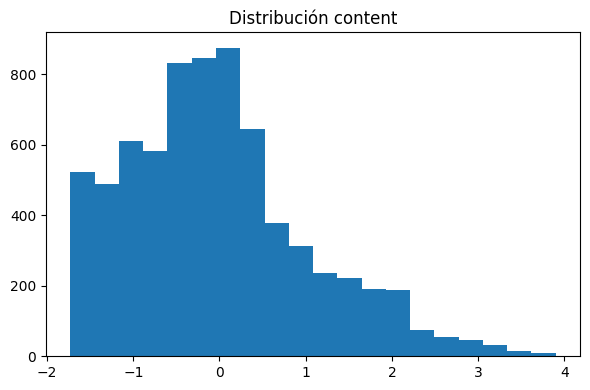

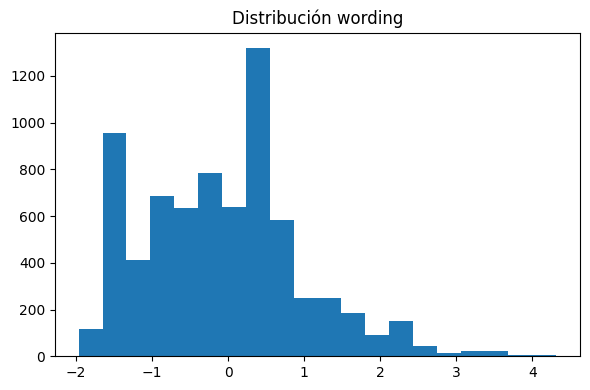

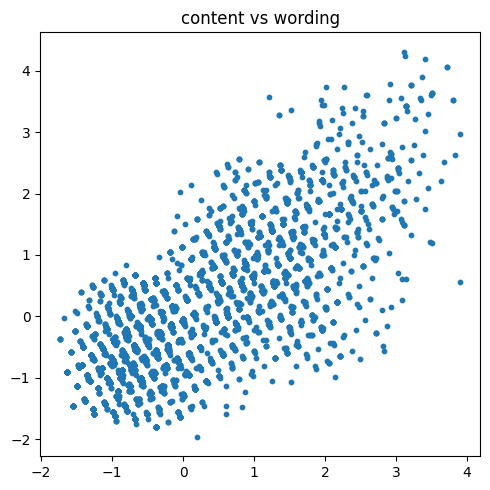

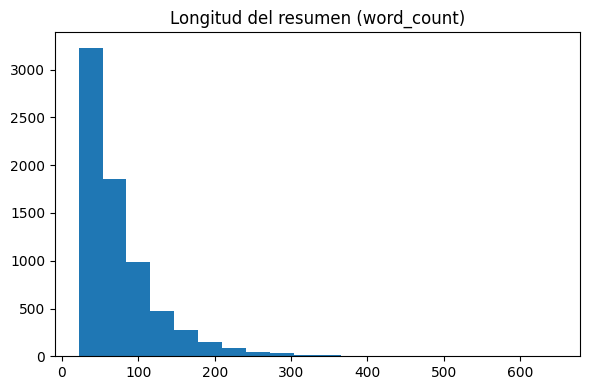

In [3]:
# EDA básico
import numpy as np
import matplotlib.pyplot as plt

print("Filas:", len(df), "| Prompts únicos:", df['prompt_id'].nunique())
print("\nMissing values:\n", df.isnull().sum())

df['text_proc'] = df['text'].fillna("").astype(str).str.lower()
df['char_count'] = df['text_proc'].str.len().astype(float)
df['word_count'] = df['text_proc'].str.split().apply(len).astype(float)
df['avg_word_len'] = df['text_proc'].apply(lambda s: (np.mean([len(w) for w in s.split()]) if len(s.split())>0 else 0.0)).astype(float)
df['unique_word_ratio'] = df['text_proc'].apply(lambda s: (len(set(s.split()))/(len(s.split())+1e-9) if isinstance(s,str) else 0.0)).astype(float)

plt.figure(figsize=(6,4)); plt.hist(df['content'].dropna().values, bins=20); plt.title("Distribución content"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); plt.hist(df['wording'].dropna().values, bins=20); plt.title("Distribución wording"); plt.tight_layout(); plt.show()
plt.figure(figsize=(5,5)); plt.scatter(df['content'].values, df['wording'].values, s=10); plt.title("content vs wording"); plt.tight_layout(); plt.show()
plt.figure(figsize=(6,4)); plt.hist(df['word_count'].dropna().values, bins=20); plt.title("Longitud del resumen (word_count)"); plt.tight_layout(); plt.show()


## Algoritmos de aprendizaje de máquinas a usar y justificación

- **Ridge (L2)**: baseline lineal robusto en alta dimensión (TF–IDF+SVD), controla sobreajuste y funciona bien con relaciones aproximadamente lineales.
- **RandomForest Regressor**: captura **no linealidades** e interacciones entre componentes latentes y rasgos numéricos sin requerir escalado.
- **LinearSVR**: optimiza un margen ε-insensible; con representaciones densas (SVD) puede generalizar mejor en presencia de *outliers* moderados.

**Representación**: TF–IDF con n-gramas (1–2) + SVD (LSA) para compactar a componentes densos; se agregan rasgos simples (longitud, vocabulario único, etc.).  
**Validación**: **GroupKFold por `prompt_id`** para evaluar generalización a *prompts* no vistos.


In [4]:
# Features: TF-IDF + SVD + num features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

df['prompt_all'] = (df['prompt_title'].fillna('') + ' ' + df['prompt_text'].fillna('') + ' ' + df['prompt_question'].fillna('')).str.strip()
df['text_all'] = (df['text_proc'] + ' ' + df['prompt_all'].str.lower()).str.strip()

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2)
X_tfidf = tfidf.fit_transform(df['text_all'].tolist())
svd = TruncatedSVD(n_components=150, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

num_feats = ['char_count','word_count','unique_word_ratio','avg_word_len']
X_num = df[num_feats].to_numpy(dtype=float)

X = np.hstack([X_svd, X_num])
y = df[['content','wording']].to_numpy(dtype=float)
groups = df['prompt_id'].to_numpy()
X.shape, y.shape


((7165, 154), (7165, 2))

In [7]:
# Modelos y validación GroupKFold
from sklearn.model_selection import GroupKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def evaluate_models_group_rmse(X, y, groups, models, n_splits=4):
    gkf = GroupKFold(n_splits=n_splits)
    results = []
    oof_by_model = {}
    for mname, reg in models.items():
        rmse_all, rmse_c, rmse_w = [], [], []
        oof_pred = np.zeros_like(y)
        for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups)):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]
            reg.fit(X_tr, y_tr)
            y_hat = reg.predict(X_va)
            oof_pred[va_idx] = y_hat
            rmse_c.append(mean_squared_error(y_va[:,0], y_hat[:,0], squared=False))
            rmse_w.append(mean_squared_error(y_va[:,1], y_hat[:,1], squared=False))
            rmse_all.append(mean_squared_error(y_va, y_hat, squared=False))
        results.append({
            "model": mname,
            "rmse_mean": float(np.mean(rmse_all)),
            "rmse_std": float(np.std(rmse_all)),
            "rmse_content": float(np.mean(rmse_c)),
            "rmse_wording": float(np.mean(rmse_w)),
            "splits": n_splits
        })
        oof_by_model[mname] = oof_pred
    res_df = pd.DataFrame(results).sort_values("rmse_mean").reset_index(drop=True)
    return res_df, oof_by_model

models = {
    "Ridge (L2)": MultiOutputRegressor(Ridge(alpha=1.0, random_state=42)),
    "RandomForest": RandomForestRegressor(n_estimators=350, max_depth=None, random_state=42, n_jobs=-1),
    "LinearSVR": MultiOutputRegressor(LinearSVR(epsilon=0.1, C=1.0, random_state=42)),
}

results_df, oof_by_model = evaluate_models_group_rmse(X, y, groups, models, n_splits=4)
results_df


c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

,model,rmse_mean,rmse_std,rmse_content,rmse_wording,splits
0,RandomForest,0.667631,0.034983,0.531144,0.780216,4
1,LinearSVR,1.282311,0.307470,0.877683,1.559893,4
2,Ridge (L2),3.009435,0.240622,1.705431,3.893754,4


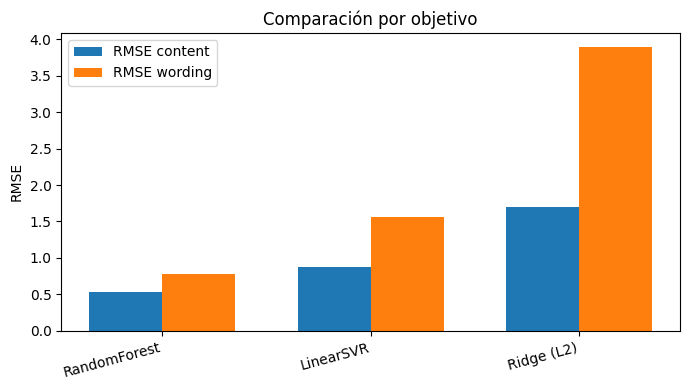

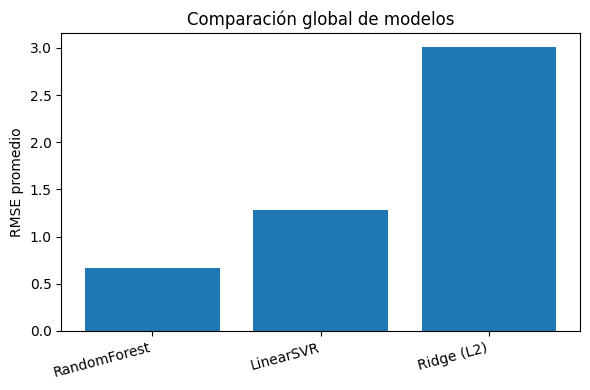

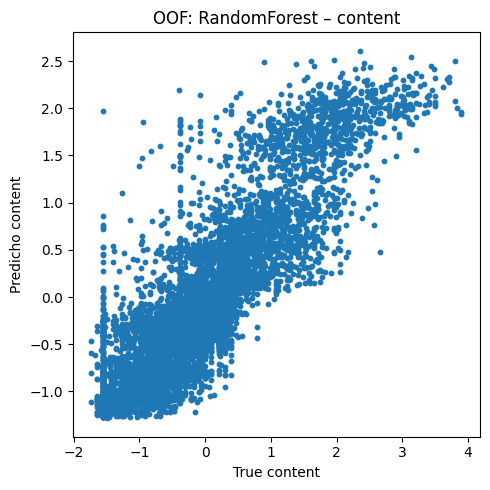

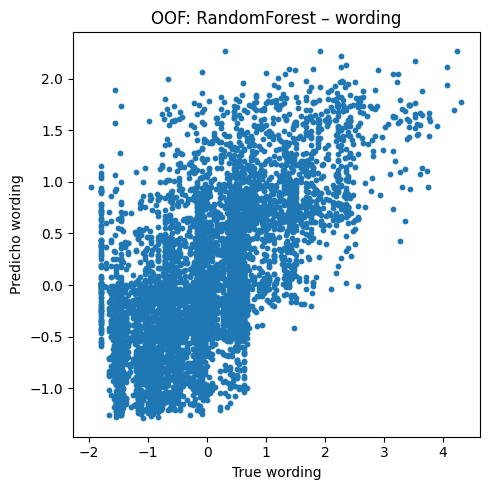

In [8]:
# Visualizaciones comparativas
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
x = np.arange(len(results_df)); bw = 0.35
plt.bar(x - bw/2, results_df['rmse_content'].values, width=bw, label='RMSE content')
plt.bar(x + bw/2, results_df['rmse_wording'].values, width=bw, label='RMSE wording')
plt.xticks(x, results_df['model'].tolist(), rotation=15, ha='right')
plt.ylabel('RMSE'); plt.title('Comparación por objetivo')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.bar(np.arange(len(results_df)), results_df['rmse_mean'].values)
plt.xticks(np.arange(len(results_df)), results_df['model'].tolist(), rotation=15, ha='right')
plt.ylabel('RMSE promedio'); plt.title('Comparación global de modelos')
plt.tight_layout(); plt.show()

best_name = results_df.iloc[0]['model']
best_oof = oof_by_model[best_name]

plt.figure(figsize=(5,5))
plt.scatter(y[:,0], best_oof[:,0], s=10)
plt.xlabel("True content"); plt.ylabel("Predicho content")
plt.title(f"OOF: {best_name} – content")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.scatter(y[:,1], best_oof[:,1], s=10)
plt.xlabel("True wording"); plt.ylabel("Predicho wording")
plt.title(f"OOF: {best_name} – wording")
plt.tight_layout(); plt.show()


## Conclusiones

- El mejor modelo es el que logra **menor RMSE promedio** sobre *GroupKFold* por `prompt_id` (ver tabla y gráficas).
- **Ridge (L2)** suele ser un baseline fuerte con TF–IDF+SVD; **RandomForest** incorpora no linealidad; **LinearSVR** aporta margen máximo.
- Posibles mejoras: *tuning* de hiperparámetros (Grid/Random), **Elastic Net** y **HistGradientBoostingRegressor** (vía `MultiOutputRegressor`), aumentar componentes de SVD, usar n-gramas (1–2), y enriquecer *features* (similaridad con el prompt, *readability*, etc.).


## Bibliografia

Cortes, C., Mohri, M., & Rostamizadeh, A. (2012). L2 Regularization for Learning Kernels. arXiv (Cornell University). https://doi.org/10.48550/arxiv.1205.2653

García-Floriano, A., López-Martín, C., Yáñez-Márquez, C., & Abran, A. (2018). Support vector regression for predicting software enhancement effort. Information And Software Technology, 97, 99-109. https://doi.org/10.1016/j.infsof.2018.01.003 

Hastie, T. (2020). Ridge Regularization: An Essential Concept in Data Science. Technometrics, 62(4), 426-433. https://doi.org/10.1080/00401706.2020.1791959 

Mahesh, B. (2020). Machine Learning Algorithms - a review. International Journal Of Science And Research (IJSR), 9(1), 381-386. https://doi.org/10.21275/art20203995 

R, P., G, D., T, R. K., & B, S. P. (2021). Study on machine learning algorithms. International Journal Of Scientific Research In Computer Science Engineering And Information Technology, 67-72. https://doi.org/10.32628/cseit2173105 

Salman, H. A., Kalakech, A., & Steiti, A. (2024). Random Forest Algorithm Overview. Deleted Journal, 2024, 69-79. https://doi.org/10.58496/bjml/2024/007 